## Towards Marginal Likelihood in Julia (AIS / GRIS / MC-IS / AMIS)
Our alphabet soup here:
* Annealed Importance Sampling
* Gradient Importance Sampling
* Monte-Carlo Importance Sampling
* Adaptive Mixture Importance Sampling

My belief is that these ideas are each fairly powerful and while often overlapping, also to a certain extent complementary. If used together, particularly if finished off with defensive importance sampling, may prove to be a useful way to calculate the evidence / marginal likelihood of a probabilistic model. This is something like part III or IV of a bunch of notebooks exploring these kinds of ideas (and teaching myself Julia!)

Cappé, O., Douc, R., Guillin, A., Marin, J. M., & Robert, C. P. (2008). Adaptive importance sampling in general mixture classes. Statistics and Computing, 18(4), 447-459.<br>
Neal, R. M. (2001). Annealed importance sampling. Statistics and computing, 11(2), 125-139.<br>
Schuster, I. (2015). Gradient importance sampling. arXiv preprint arXiv:1507.05781.<br>
Del Moral, P., Doucet, A., & Jasra, A. (2006). Sequential monte carlo samplers. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 68(3), 411-436.<br>

@article{cappe2008adaptive,
  title={{Adaptive Importance Sampling in General Mixture Classes}},
  author={Capp{\'e}, Olivier and Douc, Randal and Guillin, Arnaud and Marin, Jean-Michel and Robert, Christian P},
  journal={Statistics and Computing},
  volume={18},
  number={4},
  pages={447--459},
  year={2008},
  publisher={Springer}
}
@article{neal2001annealed,
  title={{Annealed Importance Sampling}},
  author={Neal, Radford M},
  journal={Statistics and computing},
  volume={11},
  number={2},
  pages={125--139},
  year={2001},
  publisher={Springer}
}
@article{schuster2015gradient,
  title={{Gradient Importance Sampling}},
  author={Schuster, Ingmar},
  journal={arXiv preprint arXiv:1507.05781},
  year={2015}
}
@article{del2006sequential,
  title={{Sequential Monte Carlo Samplers}},
  author={Del Moral, Pierre and Doucet, Arnaud and Jasra, Ajay},
  journal={Journal of the Royal Statistical Society: Series B (Statistical Methodology)},
  volume={68},
  number={3},
  pages={411--436},
  year={2006},
  publisher={Wiley Online Library}
}

To prevent another wholesale repetition from previous notebooks, I've included the most useful functions so far into a 'utils' package

In [1]:
include("./abutils.jl")

Main.abutils

In [2]:
splat = abutils.unpack_arr
gaussian_2D_level_curve = abutils.gaussian_2D_level_curve
eye(d) = Matrix(I, d, d)
logical_not(x) = x .== false

logical_not (generic function with 1 method)

In [3]:
using PyPlot
using Distributions
using LinearAlgebra
using Formatting
using Flux
using Flux: Tracker
using StatsBase
using Clustering
using Parameters
using Random

### Setup a toy problem
## Un peu de banane!

In [4]:
function p_log_banana(X)
    b = 100
    s = 0.03
    div1 = 10.
    x1 = X[:,1]./div1
    return -x1.^2/(2*s) - 0.5*(X[:,2] - b.*(x1.^2 .- s)).^2
end

function p_log_banana_beta(x, beta)
    f_x = p_log_banana(x)
    return (1-beta)*p_log_prop(x) + beta*f_x, f_x
end

p_log_banana_beta (generic function with 1 method)

In [5]:
out = zeros(81,81)
for (i, ii_x) in enumerate(-4:0.1:4)
    for (j, ii_y) in enumerate(-4:0.1:4)
        out[i,j] = p_log_banana([ii_x ii_y])[1,1]
    end
end

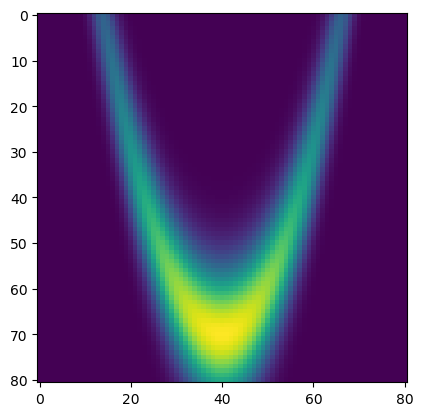

PyObject <matplotlib.image.AxesImage object at 0xa26a5cb70>

In [6]:
PyPlot.plt[:imshow](reverse(exp.(out)', dims=1))

### Define the key logsumexp / softmax functions for autograd

In [7]:
# yanked from https://github.com/JuliaStats/StatsFuns.jl/blob/master/src/basicfuns.jl
# with a couple of mods
using Flux.Tracker: TrackedReal, track, @grad


function logsumexp(X::AbstractArray{T}) where {T<:Real}
    isempty(X) && return log(zero(T))
    u = maximum(X)
    isfinite(u) || return float(u)
    let u=u # avoid https://github.com/JuliaLang/julia/issues/15276
        u + log.(sum(x -> exp.(x-u), X))
    end
end

function logsumexprows(X::AbstractArray{T}) where {T<:Real}
    n = size(X,1)
    out = zeros(n)
    for i = 1:n
        out[i] = logsumexp(X[i,:])
    end
    return out
end   


function softmax2(logp; dims=2)
    p = exp.(logp .- maximum(logp, dims=dims))
    p ./= sum(p, dims=dims)
    return p
end

# PLUG INTO FLUX
logsumexprows(X::TrackedArray) = Tracker.track(logsumexprows, X)

@grad function logsumexprows(X)
  return logsumexprows(X.data), Δ -> (Δ .* softmax2(Δ.*X.data),)
end

In [8]:
function softmaxbatch(logp; dims=2)
    u = maximum(logp, dims=dims)
#     u = (dims == 2) ? u : u'
    p = exp.(logp .- u)
    return p / sum(p)
end

softmaxbatch (generic function with 1 method)

### Define the log probabilities
These have some tests just to make sure too

In [9]:
# model definition
const prop_var = 10^2
# implicitly proposal mean is 0

function p_log_prop(X)
    @assert ndims(X) == 2
    n, d = size(X)
    @assert d != 1
    Z = X .* (1/sqrt(prop_var))
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -(d/2)*log(2*pi*prop_var)
    return exponent .+ lognormconst
end

eff_ss(W) = 1/sum((W./sum(W)).^2)
weight_perp(W) = let w=W/sum(W); -sum(w.* log.(w))/log(length(W)) end

function p_log_beta(x, beta)
    f_x = p_log_target(x)
    return (1-beta)*p_log_prop(x) + beta*f_x, f_x
end

p_log_beta (generic function with 1 method)

##### Test Proposal Density vs. julia builtin

In [10]:
maxdelta = 0
for i in range(1, stop=1000)
    x = randn(1,2)*sqrt(prop_var)
    Δ = abs.(logpdf(MvNormal([0; 0], convert(Float64, prop_var)*abutils.eye(2)), x') - p_log_prop(x))[1,1]
    if Δ > 1e-6
        print(x)
        println(" Delta is " * sprintf1("%.7f", Δ))
    end
    global maxdelta = max(maxdelta, Δ)
end
println("maxdelta"); maxdelta

maxdelta


3.552713678800501e-15

#### Other Useful Functions

In [11]:
function plot_level_curves_all(mus, UTs; ax=Nothing, kwargs...)
    ax = ax==Nothing ? gca() : ax
    for i = 1:4
        ax[:plot](splat(gaussian_2D_level_curve(mus[i,:], UTs[i]'*UTs[i]))...; kwargs...);
    end
end

function plot_is_vs_target(S, W; ax=Nothing, kwargs...)
    rgba_colors = zeros(size(S, 1), 4)
    rgba_colors[:, 3] .= 1.0   # blue
    rgba_colors[:, 4] = W/maximum(W)   # alpha
#     print(rgba_colors)
    ax = ax==Nothing ? gca() : ax
#     plot_level_curves_all(mus, UTs; ax=ax)
    ax[:scatter](splat(S)..., c=rgba_colors)
end

plot_is_vs_target (generic function with 1 method)

In [12]:
function eta_t(t)
    delta = 0.1
    return delta * exp(-0.02 * t)
end

eta_t (generic function with 1 method)

In [13]:
macro noopwhen(condition, expression)
    quote
        if !($condition)
            $expression
        end
    end |> esc
end

@noopwhen (macro with 1 method)

### Re-introducing GRIS!

In [14]:
function gradient_importance_sample_gauss(epochs, n_samples, log_f; burnin=0, test=true, prior_std=10.)
    @assert burnin < epochs
    
    sqrtdelta = 1
    S = zeros(n_samples*epochs, 2)
    W = zeros(n_samples*epochs)
    
    # Make initial proposal from prior
    μ_init = [0 0]'
    x = randn(n_samples, 2) .* prior_std .+ μ_init'
    S[1:n_samples,:] = x
    
    # ... allow for resampling of all (in principle)
    W[1:n_samples] .= 1
    
    @noopwhen !test f, axs = PyPlot.subplots(11,3, figsize=(10,20))
    @noopwhen !test axs[1,1][:scatter](splat(x)...)
    @noopwhen !test plot_is_vs_target(S[1:n_samples,:], exp.(W[1:n_samples]), ax=axs[1,2])
    @noopwhen !test display(reduce(hcat, [S[1:n_samples,1], S[1:n_samples,2], W[1:n_samples], log_f(x)[1]]))
    
    # ===> GRIS LOOP <====
    for t = range(1, stop=epochs)
        
        nodisp = (!test || t>10)
        # sample previous particles for this epoch
        begin
            min_rng = 1 + max(0, n_samples*t-1200)
            max_rng = n_samples*max(1, t-1)
            ixs = abutils.smp_from_logprob(n_samples, W[min_rng:max_rng])  .+ min_rng .- 1
        end
        
        x = S[ixs,:]
        
        @noopwhen nodisp axs[t+1,1][:scatter](splat(x)...)
        
        # get gradient / Langevin proposal
        # --- calculate gradient ---
        η = eta_t(t)  
        x_track = param(x)
        lp = log_f(x_track)[1]
        Tracker.back!(sum(lp))
        
        c_mus = x .+ 0.0.*η .* x_track.grad
        # --------------------------
        
        # Sample from proposal
        xprime = c_mus .+ sqrtdelta*randn(n_samples, 2)
        @noopwhen nodisp axs[t+1,3][:scatter](splat(xprime)...)
        
        # calculate importance weight
        begin
            dist_metric = abutils.sq_diff_matrix(xprime, c_mus) ./ (2*sqrtdelta^2)
            lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
            
            @noopwhen !test begin
                lq_u2 = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*log(det(2*pi*sqrtdelta^2 * eye(2)))
                q_n = mapslices(x -> [mean([pdf(MvNormal(c_mus[i,:], sqrtdelta^2*eye(2)), x) 
                                      for i in 1:n_samples])], xprime, dims=2)
                print(unique(map(x->round(x, digits=5), exp.(lq_u2) ./exp.(lq_u))))   # ratio to exact quick calc
                println(unique(map(x->round(x, digits=5), q_n ./exp.(lq_u))))  # ratio to built-in Julia MVN
            end
                         
            w = log_f(xprime)[1] .- lq_u  # may be able to get rid of f_log_target if we resample as in Schuster
                                            # i.e. calculate in the gradient block in next iter.
        end
        
        # Store particles / weights
        S[1+n_samples*(t-1):n_samples*t, :] = xprime
        W[1+n_samples*(t-1):n_samples*t] = w
    end
    
    if burnin > 0
        S = S[n_samples*burnin+1:end, :]; W = W[n_samples*burnin+1:end]
    end
    
    return S, abutils.fastexp.(W)
end

gradient_importance_sample_gauss (generic function with 1 method)

50×4 Array{Float64,2}:
 -12.764      -3.81234     1.0  -13431.1      
  -1.43442    10.408       1.0     -64.7591   
  -0.941226    2.31584     1.0      -9.95979  
   2.3202      1.82598     1.0      -1.05254  
  -0.350263    9.98352     1.0     -82.721    
   4.38316    -1.43921     1.0    -158.986    
  -0.659579   10.9573      1.0     -91.4981   
  16.9678      3.46037     1.0  -39653.6      
  10.5784    -16.6099      1.0   -7895.36     
   0.764473    5.7771      1.0     -33.6574   
  -3.40125   -11.0151      1.0    -193.686    
   5.89826     2.36129     1.0    -438.809    
   0.567028   -2.89862     1.0      -0.0778169
   ⋮                                          
  -0.913879    5.31276     1.0     -28.0963   
   4.47935   -10.8788      1.0    -393.758    
   5.77146    -3.37614     1.0    -572.921    
  -8.50882    -5.27545     1.0   -2800.28     
  -2.64338     1.27713     1.0      -4.83748  
  -8.29302    -5.06382     1.0   -2520.47     
  -1.78185    -1.79156     1.0      -

[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]


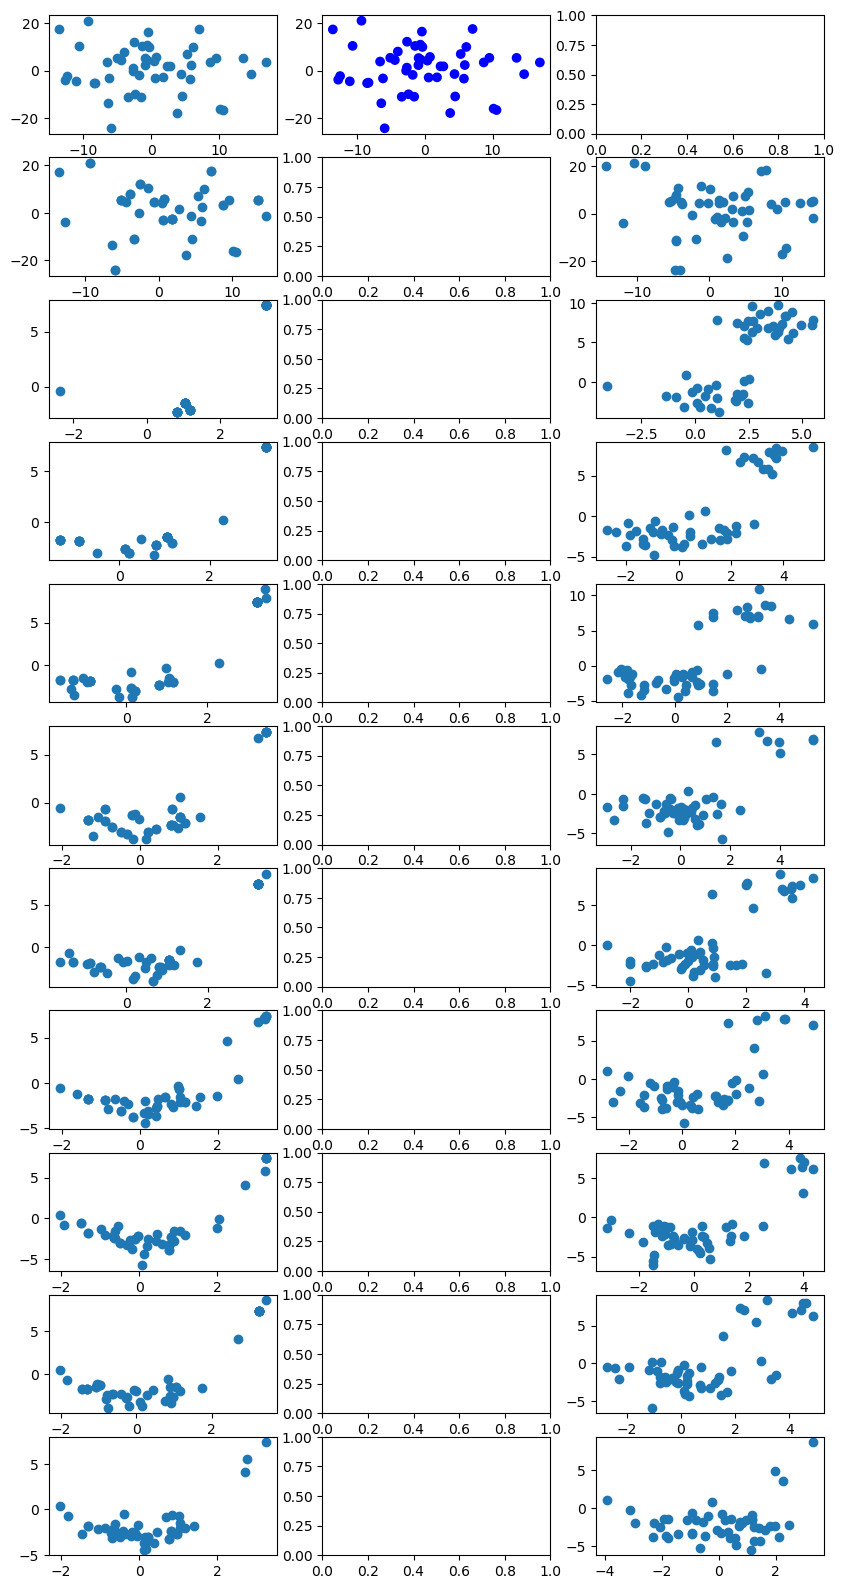

[1.0][1.0]


([4.24285 8.09489; 2.37428 8.12164; … ; -1.23147 -1.67808; 0.483485 -1.70339], [7.22517e-10, 3.42009e-5, 5.14316, 0.00100847, 1.31367, 5.36969, 0.00143807, 122.416, 11.4918, 5.6405  …  7.30802, 12.9669, 17.2131, 1.73042, 10.3711, 6.23377, 1.13256, 21.6303, 16.2842, 10.9733])

In [15]:
S, W = gradient_importance_sample_gauss(50, 50, x -> p_log_banana_beta(x,1.0), burnin=20, test=true, prior_std=10.)

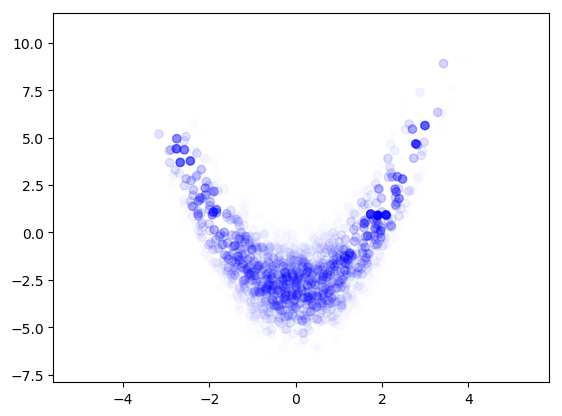

PyObject <matplotlib.collections.PathCollection object at 0xa362b41d0>

In [16]:
plot_is_vs_target(S, W)

### Issues
* Due to the resampling stage, particles are not given much time to explore the space initially. Only those that happen to hit the mark are typically chosen, and so the multi-modal aspects of the problem are undeveloped.
* If an unlikely sample from an existing atom happen to stumble upon an area of higher density, a huge weight is given. This is problematic not only for the current epoch, but for the next 20, since this weight is likely to be *much* higher than anything else that comes next. Thus a huge amount of sampling can be done in an unprofitable area.

Solutions
* Anneal the weights so we do not get rid of samples that are near the typical set at the expense of those right in the middle.
* Only resample every $L$ steps so that a sort of Langevin MC / descent idea is followed, allowing all particles to get near the different modes.

## Defining a SMC Samplers Approach
Here we blend GRIS with Langevin-like Markov Chains and annealing distributions.


In the below struct one can specify the annealing schedule in the `betas` parameter. The other key parameter is `resample_every` which gives the opportunity to run the chains closer to regions of high density before resampling. Essentially this is just a stronger proposal density which is defined by something not entirely dissimilar to MCMC.

In [17]:
@with_kw struct smcs_opt
    resample_every::Int64 = 1 
    sqrtdelta::Float64 =1.
    betas::Array{Float64} = [1.]
    test::Bool = false
    grad_delta::Float64 = 1.0
    burnin::Int64 = 0
    n_init::Int64 = 1000
    prior_std::Float64 = 10.
end

smcs_opt

In [18]:
function smcs_grad(epochs, n_samples, log_f; opts=smcs_opt())
    @assert opts.burnin < epochs
    @assert isa(opts, smcs_opt)
    @assert epochs % opts.resample_every == 0 "epochs should be a multiple of the resampling points"
    
    @unpack test, resample_every, sqrtdelta, grad_delta = opts
    δ = grad_delta
    n_β = length(opts.betas)
    n_β > opts.burnin && println("WARNING: BURN IN SHORTER THAN ANNEALING TIME")
        
    S = zeros(n_samples*epochs, 2)
    W = zeros(n_samples*epochs)
    Wfinal = zeros(n_samples*epochs)
    
    # Make initial proposal from prior
    μ_init = [0 0]'
    x = randn(n_samples, 2) .* opts.prior_std .+ μ_init'
#     S[1:n_samples,:] = x
    
    @noopwhen !test f, axs = PyPlot.subplots(13,3, figsize=(10,22))
    @noopwhen !test axs[1,1][:scatter](splat(x)...)
    @noopwhen !test plot_is_vs_target(S[1:n_samples,:], exp.(W[1:n_samples]), ax=axs[1,2])
    @noopwhen !test display(reduce(hcat, [S[1:n_samples,1], S[1:n_samples,2], W[1:n_samples], log_f(x, opts.betas[1])[1]]))
    
    # ===> GRIS LOOP <====
    for t = range(1, stop=epochs)
        
        nodisp = (!test || t>12)
        β = opts.betas[min(t, n_β)]
        
        @noopwhen nodisp axs[t+1,1][:scatter](splat(x)...)
        
        # get gradient / Langevin proposal
        # --- calculate gradient ---
        η = eta_t(t)  
        x_track = param(x)
        lp = log_f(x_track, 1.)[1]   # also spits out just log_f in second retval (a.o.to beta mix)
        Tracker.back!(sum(lp))
        
        c_mus = x .+ δ.*η .* x_track.grad
        # --------------------------

        @noopwhen nodisp axs[t+1,2][:scatter](splat(c_mus)...)
        
        # Sample from proposal
        xprime = c_mus .+ sqrtdelta*randn(n_samples, 2)
        @noopwhen nodisp axs[t+1,3][:scatter](splat(xprime)...)
        
        # calculate importance weight
        begin
            dist_metric = abutils.sq_diff_matrix(xprime, c_mus) ./ (2*sqrtdelta^2)
            lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
            
            @noopwhen true begin
                lq_u2 = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*log(det(2*pi*sqrtdelta^2 * eye(2)))
                q_n = mapslices(x -> [mean([pdf(MvNormal(c_mus[i,:], sqrtdelta^2*eye(2)), x) 
                                      for i in 1:n_samples])], xprime, dims=2)
                print(unique(map(x->round(x, digits=5), exp.(lq_u2) ./exp.(lq_u))))   # ratio to exact quick calc
                println(unique(map(x->round(x, digits=5), q_n ./exp.(lq_u))))  # ratio to built-in Julia MVN
            end
            
            l_anneal, lp = log_f(xprime, β)
            w = l_anneal .- lq_u  # may be able to get rid of f_log_target if we resample as in Schuster
                                           # i.e. calculate in the gradient block in next iter.
        end
        
        # Store particles / weights & Resample (or just continue!)
        S[1+n_samples*(t-1):n_samples*t, :] = xprime
        W[1+n_samples*(t-1):n_samples*t] = w
        Wfinal[1+n_samples*(t-1):n_samples*t] = lp .- lq_u
        
        if t % resample_every == 0
            # RESAMPLE
            begin
                min_rng = 1 + max(0, n_samples*t-1200)
                max_rng = n_samples*max(1, t-1)
                ixs = abutils.smp_from_logprob(n_samples, W[min_rng:max_rng])  .+ min_rng .- 1
                @noopwhen !test print("RESAMPLE.." * sprintf1("%d", min_rng) * " " * sprintf1("%d", max_rng))
                x = S[ixs,:]
                @noopwhen !test println(" Done!")
            end
        else
            x = xprime
        end
    end
    
    if opts.burnin > 0
        ix_start = n_samples*opts.burnin+1
        S = S[ix_start:end, :]; W = Wfinal[ix_start:end]
    end
    
    return S, abutils.fastexp.(W)
end

smcs_grad (generic function with 1 method)

In [19]:
function smcs_grad2(epochs, n_samples, log_f; opts=smcs_opt())
    @assert opts.burnin < epochs
    @assert isa(opts, smcs_opt)
    @assert epochs % opts.resample_every == 0 "epochs should be a multiple of the resampling points"
    
    @unpack test, resample_every, sqrtdelta, grad_delta = opts
    δ = grad_delta
    n_β = length(opts.betas)
    n_β > opts.burnin && println("WARNING: BURN IN SHORTER THAN ANNEALING TIME")
        
    S = zeros(n_samples*epochs, 2)
    W = zeros(n_samples*epochs)
    Wfinal = zeros(n_samples*epochs)
    
    @noopwhen !test f, axs = PyPlot.subplots(13,3, figsize=(10,22))
    
    # Make initial proposal from prior
    μ_init = [0 0]'
    σ_init = opts.prior_std

    # ===> INITIALISATION <====
    begin
        x_init = randn(opts.n_init, 2) .* σ_init .+ μ_init'
        β = opts.betas[min(1, n_β)]
        η = eta_t(1)
        
        # multi-step (30) Langevin proposal
        c_mus = zeros(opts.n_init, 2)
        for _init_idx in 1:30  
            x_init_track = param(x_init)
            lp = log_f(x_init_track, 1.)[1]   # also spits out just log_f in second retval (a.o.to beta mix)
            Tracker.back!(sum(lp))
            c_mus = x_init .+ δ.*η .* x_init_track.grad
            x_init = c_mus .+ sqrtdelta*randn(opts.n_init, 2)
        end
        
        # calculate importance weight
        dist_metric = abutils.sq_diff_matrix(x_init, c_mus) ./ (2*sqrtdelta^2)
        lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
        l_anneal, lp = log_f(x_init, β)
        w = l_anneal .- lq_u
        
        # RESAMPLE
        ixs = abutils.smp_from_logprob(n_samples, w[:])
        x = x_init[ixs,:]
    end
    
    
    # ===> GRIS LOOP <====
    for t = range(1, stop=epochs)
        
        nodisp = (!test || t>12)
        β = opts.betas[min(t, n_β)]
        
        @noopwhen nodisp axs[t+1,1][:scatter](splat(x)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,1], color="red")
        
        # get gradient / Langevin proposal
        # --- calculate gradient ---
        begin
        η = eta_t(t)  
        x_track = param(x)
        lp = log_f(x_track, 1.)[1]   # also spits out just log_f in second retval (a.o.to beta mix)
        Tracker.back!(sum(lp))
        
        c_mus = x .+ δ.*η .* x_track.grad
        end
        # --------------------------

        @noopwhen nodisp axs[t+1,2][:scatter](splat(c_mus)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,2], color="red")
        
        # Sample from proposal
        xprime = c_mus .+ sqrtdelta*randn(n_samples, 2)
        @noopwhen nodisp axs[t+1,3][:scatter](splat(xprime)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,3], color="red")
        
        # calculate importance weight
        begin
            dist_metric = abutils.sq_diff_matrix(xprime, c_mus) ./ (2*sqrtdelta^2)
            lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
            
            @noopwhen true begin
                lq_u2 = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*log(det(2*pi*sqrtdelta^2 * eye(2)))
                q_n = mapslices(x -> [mean([pdf(MvNormal(c_mus[i,:], sqrtdelta^2*eye(2)), x) 
                                      for i in 1:n_samples])], xprime, dims=2)
                print(unique(map(x->round(x, digits=5), exp.(lq_u2) ./exp.(lq_u))))   # ratio to exact quick calc
                println(unique(map(x->round(x, digits=5), q_n ./exp.(lq_u))))  # ratio to built-in Julia MVN
            end
            
            l_anneal, lp = log_f(xprime, β)
            w = l_anneal .- lq_u  # may be able to get rid of f_log_target if we resample as in Schuster
                                           # i.e. calculate in the gradient block in next iter.
        end
        
        # Store particles / weights & Resample (or just continue!)
        S[1+n_samples*(t-1):n_samples*t, :] = xprime
        W[1+n_samples*(t-1):n_samples*t] = w
        Wfinal[1+n_samples*(t-1):n_samples*t] = lp .- lq_u
        
        if t % resample_every == 0
            # RESAMPLE
            begin
                min_rng = 1 + max(0, n_samples*t-1200)
                max_rng = n_samples*max(1, t-1)
                ixs = abutils.smp_from_logprob(n_samples, W[min_rng:max_rng])  .+ min_rng .- 1
                @noopwhen !test print("RESAMPLE.." * sprintf1("%d", min_rng) * " " * sprintf1("%d", max_rng))
                x = S[ixs,:]
                @noopwhen !test println(" Done!")
            end
        else
            x = xprime
        end
    end
    
    if opts.burnin > 0
        ix_start = n_samples*opts.burnin+1
        S = S[ix_start:end, :]; W = Wfinal[ix_start:end]
    end
    
    return S, abutils.fastexp.(W)
end

smcs_grad2 (generic function with 1 method)

50×4 Array{Float64,2}:
 0.0  0.0  0.0  -259.215  
 0.0  0.0  0.0    -8.34747
 0.0  0.0  0.0    -7.30245
 0.0  0.0  0.0    -6.3969 
 0.0  0.0  0.0    -6.87903
 0.0  0.0  0.0    -8.60298
 0.0  0.0  0.0   -13.1405 
 0.0  0.0  0.0    -7.97465
 0.0  0.0  0.0  -428.398  
 0.0  0.0  0.0    -6.48876
 0.0  0.0  0.0    -7.51303
 0.0  0.0  0.0    -7.24401
 0.0  0.0  0.0  -636.588  
 ⋮                        
 0.0  0.0  0.0    -8.03414
 0.0  0.0  0.0   -11.9843 
 0.0  0.0  0.0   -16.4912 
 0.0  0.0  0.0    -7.81134
 0.0  0.0  0.0    -6.49631
 0.0  0.0  0.0   -27.6902 
 0.0  0.0  0.0  -196.183  
 0.0  0.0  0.0   -14.1389 
 0.0  0.0  0.0  -271.845  
 0.0  0.0  0.0   -38.5142 
 0.0  0.0  0.0   -27.2511 
 0.0  0.0  0.0    -8.07997

RESAMPLE..1 450 Done!

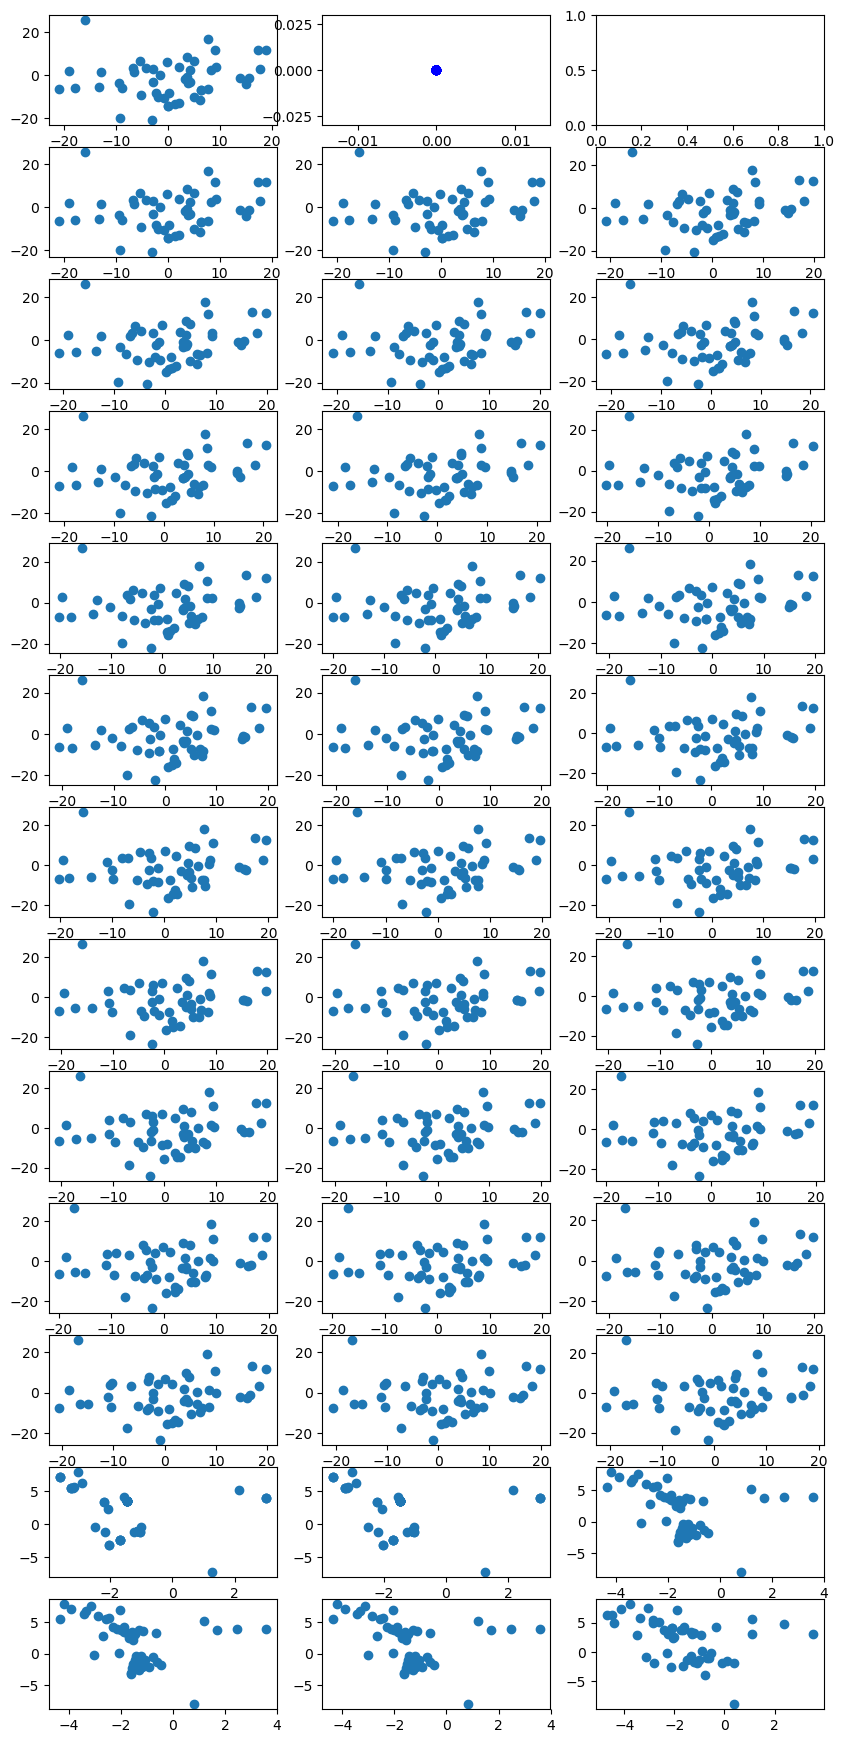


RESAMPLE..1 950 Done!
RESAMPLE..301 1450 Done!
RESAMPLE..801 1950 Done!
RESAMPLE..1301 2450 Done!
RESAMPLE..1801 2950 Done!
RESAMPLE..2301 3450 Done!
RESAMPLE..2801 3950 Done!


([-0.611625 -2.54052; -1.72945 -1.57832; … ; -0.989671 -2.90671; 0.432225 -3.30002], [23.8522, 4.39371, 5.34003, 9.71898, 3.3784, 5.45266, 9.83021, 0.433078, 10.5031, 38.5667  …  0.00030617, 0.0139444, 59.8285, 2.76846e-6, 0.00119068, 17.0978, 11.8236, 15.1037, 15.9078, 57.0224])

In [20]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=true, grad_delta=0.0, sqrtdelta=0.5, prior_std=10.)
S, W = smcs_grad(80, 50, p_log_banana_beta, opts=c_opts)

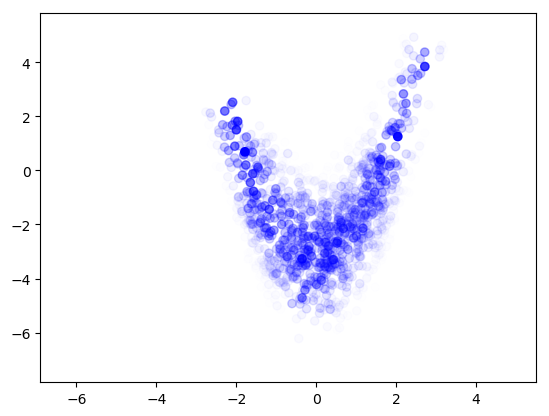

PyObject <matplotlib.collections.PathCollection object at 0xa37d8af98>

In [21]:
plot_is_vs_target(S, W)

#### Normalising Constant is close to 1

In [22]:
mean(W)

8.897799806926217

#### Little visualisation of all the samples generated during the process

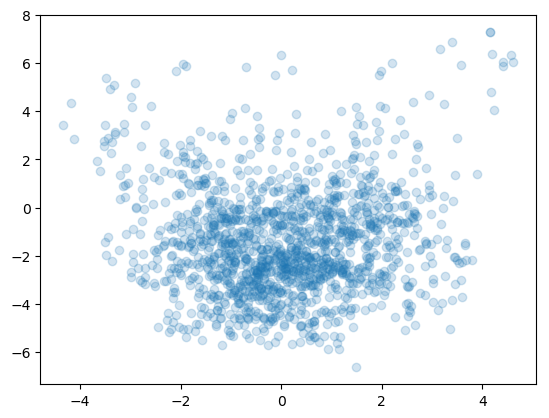

PyObject <matplotlib.collections.PathCollection object at 0xa41eb7630>

In [31]:
scatter(splat(S[W.>1e-40,:])..., alpha=0.2)

### Look at the distribution of estimates of the normalising constant.
We see there is a downward bias, and while the bias is perhaps only 3-4%, the individual estimates can be quite far off. Having said that, it is not as bad as we saw for GRIS.


<span style="color:red"><b>TODO: COMPARE WITH GRIS AND AIS AND VANILLA IS</b></span>

In [22]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=false, grad_delta=0.0, sqrtdelta=0.5, prior_std=10.)

smcs_opt
  resample_every: Int64 10
  sqrtdelta: Float64 0.5
  betas: Array{Float64}((50,)) [0.01, 0.0302041, 0.0504082, 0.0706122, 0.0908163, 0.11102, 0.131224, 0.151429, 0.171633, 0.191837  …  0.818163, 0.838367, 0.858571, 0.878776, 0.89898, 0.919184, 0.939388, 0.959592, 0.979796, 1.0]
  test: Bool false
  grad_delta: Float64 0.0
  burnin: Int64 50
  n_init: Int64 1000
  prior_std: Float64 10.0


In [23]:
normconstest = zeros(1000,1)
for i = 1:1000
    S, W = smcs_grad(60, 50, p_log_banana_beta, opts=c_opts)
    normconstest[i] = mean(W)
    i % 100 == 0 && println(i)
end

100
200
300
400
500
600
700
800
900
1000


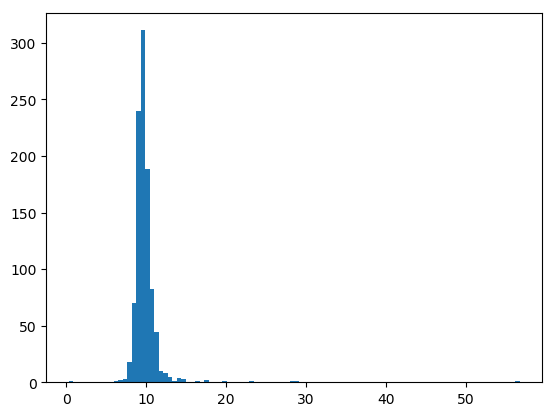

In [39]:
PyPlot.plt[:hist](sort(normconstest[:])[1:end-1], bins=100);

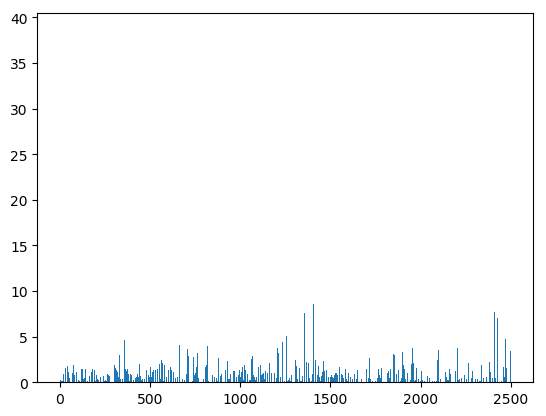

In [265]:
bar(range(1,stop=2500), W);

In [40]:
println("Effective Sum of Squares: " * sprintf1("%.3f", eff_ss(W)) * 
    "\nNormalised Perplexity: " * sprintf1("%.6f", weight_perp(W)))

Effective Sum of Squares: 475.062
Normalised Perplexity: 0.900944


## Adaptive Mixture Importance Sampling
The above appears reasonably good at finding modes of the posterior. This is a great initialisation for an adaptive mixture model approach.

We proceed by taking (weighted) kmeans of the samples generated, and using to fit a GMM. We can then iterate with generating from a (tilted) GMM and updating the components.

#### Defining functions for testing convergence of EM.
These are not that useful in practice since (1) it is expensive, (2) they fail! (but it is more likely that it is the test functions that are wrong, indeed this is usually my experience of EM.. (!) The amount of time it will take me to get this right is not justified when from various visualisations, the GMM code seems to be doing the right thing. 

(I appreciate that this is not a strong justification, but for release, I can return to this.)


In [32]:
function gmm_llh(X, weights, pis, mus, sigmas)
    n, p = size(X)
    k = length(pis)
    thrsh_comp = 0.005
    inactive_ixs = pis[:] .< thrsh_comp
    
    P = zeros(n, k)
    for j = 1:k 
        P[:,j] = log_gauss_llh(X, mus[j,:], sigmas[:,:,j], 
            bypass=inactive_ixs[j]) .+ log(pis[j])
    end
    P .*= weights
    return logsumexprows(P)
end

function gmm_prior_llh(pis, mus, sigmas, pi_prior, mu_prior, cov_prior)
    d = size(cov_prior, 1)
    ν = pi_prior # alias
    k = length(pis)
    out = zeros(k)
    for j = 1:k
        out[j] += logpdf(MvNormal(mu_prior[j,:], sigmas[:,:,j]/ν[j]), mus[j,:])
        out[j] += -(ν[j] + d + 1)*logdet(sigmas[:,:,j])/2 
        out[j] += -ν[j]*sum(diag(cov_prior[:,:,j]*inv(sigmas[:,:,j])))/2
        out[j] += (ν[j] - 1)*log(pis[j])
    end
    return sum(out)
end


# ==> THIS FUNCTION IS **SO** MUCH FASTER THAN USING MVNORMAL

# function log_gauss_llh_ppi(X, mu, sigma, pi, sNs; bypass=false)
# #     try
#         return bypass ? -ones(size(X, 1))*Inf : _log_gauss_llh(X, mu, sigma)
# #     catch e
# #         display(mu)
# #         display(sigma)
# #         display(pi)
# #         display(sNs)
# #         rethrow(e)
# #     end
# end


function log_gauss_llh(X, mu, sigma; bypass=false)
    if bypass 
        return -ones(size(X, 1))*Inf
    else
        retval = try _log_gauss_llh(X, mu, sigma)
            catch e
                return -ones(size(X, 1))*Inf
        end
        return retval
    end
end
    
function _log_gauss_llh(X, mu, sigma)
    d = size(X,2)
#     invUT = Matrix(cholesky(inv(sigma)).U)
    invUT = inv(cholesky(sigma).L)
    Z = (X .- mu')*invUT'
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -d*log(2*pi)/2 -0.5*logdet(sigma) #.+ sum(log.(diag(invUT)))
    return exponent .+ lognormconst
end

_log_gauss_llh (generic function with 1 method)

In [25]:
maxdelta = 0
for i in range(1, stop=1000)
    mu = rand(2) .- 0.5
    sigma = randn(2,2)
    sigma = sigma'sigma
    x = randn(1,2)
    Δ = abs.(logpdf(MvNormal(mu, sigma), x') - _log_gauss_llh(x, mu, sigma))[1,1]
    if Δ > 1e-6
        print(x)
        println(" Delta is " * sprintf1("%.7f", Δ))
        println(mu)
        println(sigma)
        println("Condition number is "* sprintf1("%.3f", cond(sigma)))
    end
    global maxdelta = max(maxdelta, Δ)
end
println("maxdelta"); maxdelta

[-1.4892 2.02892] Delta is 0.0000033
[-0.3551, -0.374887]
[1.8373 -2.30624; -2.30624 2.89488]
Condition number is 1381569.741
[-0.527181 0.418731] Delta is 0.0019114
[0.491458, 0.0906981]
[3.83274 3.87953; 3.87953 3.9269]
Condition number is 21657080.556
maxdelta


0.001911388710141182

#### Rolling my own EM implementation for GMM
since (a) julia versions break in 1.0, and (b) need to add weights; and (c) need to add priors.

In [29]:
function gmm_custom(X, weights, pi_prior, mu_prior, cov_prior; max_iter=100, tol=1e-3, verbose=true)
    n, p = size(X)
    k = length(pi_prior)
    @assert size(weights) == (n,)
    @assert size(mu_prior) == (k, p)
    @assert size(cov_prior) == (p, p, k)
    pis = pi_prior/sum(pi_prior)
    mus = copy(mu_prior)
    sigmas = copy(cov_prior)
    
    weights = weights / mean(weights)   # diff. to Cappé et al. due to prior
    
    thrsh_comp = 0.005
    inactive_ixs = pi_prior[:] .< thrsh_comp
    pi_prior = copy(pi_prior)
    Ns = zeros(6)
    
    for i in range(1, stop=max_iter)
        # E-step
        rs = reduce(hcat, map(j -> log_gauss_llh(X, mus[j,:], sigmas[:,:,j], bypass=inactive_ixs[j]), 1:k))
        try
            rs .+= log.(pis)[:]'
            catch e
            display(rs)
            display(log.(pis))
            rethrow(e)
        end
        
        rs = abutils.softmax2(rs, dims=2)
        # reweight according to importance weights (see Adaptive IS in General Mix. Cappé et al. 2008)
        rs .*= weights
        
        # M-step
        Ns = sum(rs, dims=1)
        inactive_ixs = Ns[:] .< 1
        active_ixs = logical_not(inactive_ixs)  # can't find a native NOT for BitArrays in Julia
        if any(inactive_ixs)
            pis[inactive_ixs] .= 0.
            pi_prior[inactive_ixs] .= 0.
        end
        pis = Ns[:] + pi_prior[:]
        
        pis /= sum(pis)
        
        _mus = reduce(vcat, map(j -> sum(X .* rs[:,j], dims=1) .+ pi_prior[j]*mu_prior[j,:]', findall(active_ixs)))
        _mus ./= vec(Ns[active_ixs] + pi_prior[active_ixs])
        mus[active_ixs,:] = _mus
        
        for j in findall(active_ixs)
            Δx = X .- mus[j, :]'
            Δμ = (mus[j,:] - mu_prior[j,:])'
            sigmas[:,:,j] = (Δx.*rs[:,j])'Δx + pi_prior[j]*(Δμ'Δμ + cov_prior[:,:,j])
            sigmas[:,:,j] ./= (Ns[j] + pi_prior[j] + p + 2)
            sigmas[:,:,j] = (sigmas[:,:,j] + sigmas[:,:,j]')/2 + eye(2)*1e-6
        end

#         # update complete log likelihoood
#         llh_hist[i] = sum(gmm_llh(S, W, pis, mus, sigmas)) +
#                       gmm_prior_llh(pis, mus, sigmas, pi_prior, mu_prior, cov_prior)

    end
    
    return pis, mus, sigmas
end

function sample_from_gmm(n, pis, mus, covs; shuffle=true)
    k, p = size(mus)
    Ns = rand(Multinomial(n, pis[:]))
    active_ixs = findall(Ns[:] .>= 1)
    
    ixs = hcat(vcat(1, 1 .+ cumsum(Ns[1:end-1], dims=1)), cumsum(Ns, dims=1))
    out = zeros(n, p)
    for j=active_ixs
        out[ixs[j,1]:ixs[j,2],:] = rand(MvNormal(mus[j,:], covs[:,:,j]), Ns[j])'
    end
    if shuffle
        out = out[randperm(n),:]
    end
    return out
end

sample_from_gmm (generic function with 1 method)

#### My rolled version of the AMIS algorithm


In [45]:
function AMIS(S, W, k, log_f; epochs=5, nodisp=true)
    IS_tilt = 2.0
    n, p = size(S)
    
    begin
    km = kmeans(copy(S'), k, weights=W)
    
    cmus = zeros(k,2)
    ccovs = zeros(2,2,k)
    for i in range(1, stop=k)
        ixs = findall(x -> isequal(x,i), km.assignments)
        cX = S[ixs, :]; cw = ProbabilityWeights(W[ixs])
        cmus[i,:] = cX' * cw/cw.sum
        ccovs[:,:,i] = cov(cX, cw, corrected=true)
    end
    cpis = [countmap(km.assignments)[i] for i in 1:6]/10
    
    if !nodisp
        f, axs = PyPlot.subplots(5,3, figsize=(8,12))

#         plot_level_curves_all(mus, UTs, ax=axs[1,1], color="red")
        for i = 1:k
            axs[1,1][:plot](splat(gaussian_2D_level_curve(cmus[i,:], ccovs[:,:,i]))...);
        end
    end
    
    ν_S = S; ν_W = W;
    end
    
    nsmp=1000
    
    for i = 1:epochs
        cpis, cmus, ccovs = gmm_custom(ν_S, ν_W, cpis, cmus, ccovs; max_iter=3, tol=1e-3, verbose=false);
        ν_S = sample_from_gmm(1000, cpis, cmus, ccovs*IS_tilt, shuffle=false)
        
        ν_W = log_f(ν_S) - gmm_llh(ν_S, 1, cpis, cmus, ccovs*IS_tilt);
        ν_W = abutils.fastexp.(ν_W);
        @noopwhen (nodisp || i > 5) ax = axs[(i ÷ 2) + 1, (i % 2)+1]
        @noopwhen (nodisp || i > 5) plot_is_vs_target(ν_S, ν_W, ax=ax);
        @noopwhen (nodisp || i > 5) for j = 1:6 ax[:plot](splat(gaussian_2D_level_curve(cmus[j,:], ccovs[:,:,j]))...); end
        @noopwhen (nodisp || i > 5) axs[i, 3][:scatter](splat(ν_S)..., alpha=0.2);
    end
    return ν_S, ν_W, cpis, cmus, ccovs
end

function GMM_IS(n, pis, mus, covs, log_f)
    S = sample_from_gmm(n, pis, mus, covs, shuffle=false)
    W = log_f(S) - gmm_llh(S, 1, pis, mus, covs);
    return S, abutils.fastexp.(W);
end

GMM_IS (generic function with 1 method)

In [49]:
@time _S, _W, _pi, _mu, _cov = AMIS(S, W, 6, p_log_banana, nodisp=true, epochs=30);

  0.073393 seconds (176.16 k allocations: 113.034 MiB, 23.76% gc time)


In [50]:
mean(_W)

10.928139576651057

In [51]:
@time _S, _W = GMM_IS(5000, _pi, _mu, _cov*2., p_log_banana)

  0.012517 seconds (22.26 k allocations: 4.593 MiB)


([5.25231 23.0961; 3.08267 7.7318; … ; -2.01194 3.38365; -2.06195 1.55449], [3.67548, 16.5125, 0.424756, 20.9143, 18.3404, 19.0703, 7.56962, 12.0742, 22.2945, 9.45202  …  12.6511, 8.7049, 8.01422, 4.18783, 14.8233, 13.3656, 16.8892, 5.67054, 3.69371, 16.0971])

In [52]:
normconstest = zeros(1000,1)
for i = 1:1000
    _S, _W = GMM_IS(50000, _pi, _mu, _cov*2, p_log_banana)
    normconstest[i] = mean(_W)
    i % 100 == 0 && println(i)
end

100
200
300
400
500
600
700
800
900
1000


In [53]:
mean(normconstest)

10.87641923077646

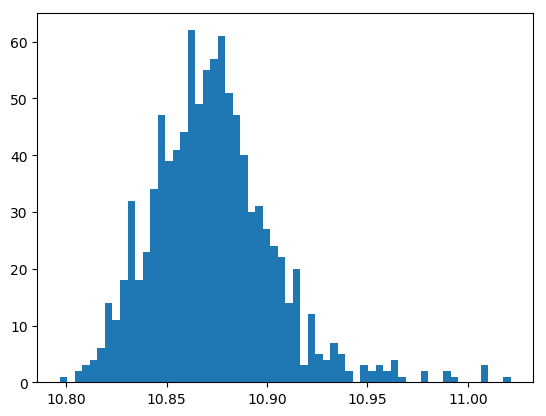

In [54]:
PyPlot.plt[:hist](sort(normconstest[:])[2:end-10], bins=60);

### End-to-end Marginal Likelihood simulation study

In [55]:
c_opts

smcs_opt
  resample_every: Int64 10
  sqrtdelta: Float64 0.5
  betas: Array{Float64}((50,)) [0.01, 0.0302041, 0.0504082, 0.0706122, 0.0908163, 0.11102, 0.131224, 0.151429, 0.171633, 0.191837  …  0.818163, 0.838367, 0.858571, 0.878776, 0.89898, 0.919184, 0.939388, 0.959592, 0.979796, 1.0]
  test: Bool false
  grad_delta: Float64 0.0
  burnin: Int64 50
  n_init: Int64 1000
  prior_std: Float64 10.0


In [56]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=false, grad_delta=1.0, sqrtdelta=0.5)

smcs_opt
  resample_every: Int64 10
  sqrtdelta: Float64 0.5
  betas: Array{Float64}((50,)) [0.01, 0.0302041, 0.0504082, 0.0706122, 0.0908163, 0.11102, 0.131224, 0.151429, 0.171633, 0.191837  …  0.818163, 0.838367, 0.858571, 0.878776, 0.89898, 0.919184, 0.939388, 0.959592, 0.979796, 1.0]
  test: Bool false
  grad_delta: Float64 1.0
  burnin: Int64 50
  n_init: Int64 1000
  prior_std: Float64 10.0


In [272]:
normconstest = ones(1000,1) * NaN
diagnostic_ss = ones(1000,2) * NaN
tmpbad = []
for i = 1:1000
    S, W = smcs_grad(60, 50, p_log_banana_beta, opts=c_opts)
    try
        S, W, pi, mu, cov = AMIS(S, W, 6, p_log_banana, epochs=30, nodisp=true);
        S, W = GMM_IS(5000, pi, mu, cov, p_log_banana)
        normconstest[i] = mean(W)
        diagnostic_ss[i,1] = eff_ss(W); diagnostic_ss[i,2] = weight_perp(W)
        i % 100 == 0 && println(i)
    catch
        @warn "FAILURE OF ATTEMPT " * sprintf1("%d", i)
    end
end

100


┌ Warning: FAILURE OF ATTEMPT 104
└ @ Main In[272]:13
┌ Warning: FAILURE OF ATTEMPT 153
└ @ Main In[272]:13


200


┌ Warning: FAILURE OF ATTEMPT 158
└ @ Main In[272]:13


300
400


┌ Warning: FAILURE OF ATTEMPT 344
└ @ Main In[272]:13


500
600
700
800


┌ Warning: FAILURE OF ATTEMPT 862
└ @ Main In[272]:13


900
1000


In [291]:
mean(trim(filter(!isnan, normconstest), prop=0.02))

10.835587854965627

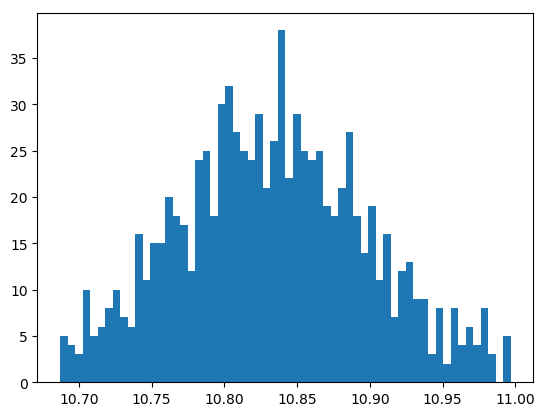

([5.0, 4.0, 3.0, 10.0, 5.0, 6.0, 8.0, 10.0, 7.0, 6.0  …  8.0, 2.0, 8.0, 4.0, 6.0, 4.0, 8.0, 3.0, 0.0, 5.0], [10.687, 10.6921, 10.6973, 10.7025, 10.7076, 10.7128, 10.718, 10.7231, 10.7283, 10.7335  …  10.9505, 10.9556, 10.9608, 10.966, 10.9711, 10.9763, 10.9815, 10.9866, 10.9918, 10.997], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0xa4a62d320>, PyObject <matplotlib.patches.Rectangle object at 0xa4a62d128>, PyObject <matplotlib.patches.Rectangle object at 0xa4a62d908>, PyObject <matplotlib.patches.Rectangle object at 0xa4a62dc88>, PyObject <matplotlib.patches.Rectangle object at 0xa4a62dfd0>, PyObject <matplotlib.patches.Rectangle object at 0xa4a6383c8>, PyObject <matplotlib.patches.Rectangle object at 0xa4a638748>, PyObject <matplotlib.patches.Rectangle object at 0xa4a638ac8>, PyObject <matplotlib.patches.Rectangle object at 0xa4a638e48>, PyObject <matplotlib.patches.Rectangle object at 0xa4a643208>  …  PyObject <matplotlib.patches.Rectangle object at 0xa4b0a53c8>,

In [280]:
PyPlot.plt[:hist](sort(filter(!isnan, normconstest))[50:end-50], bins=60)

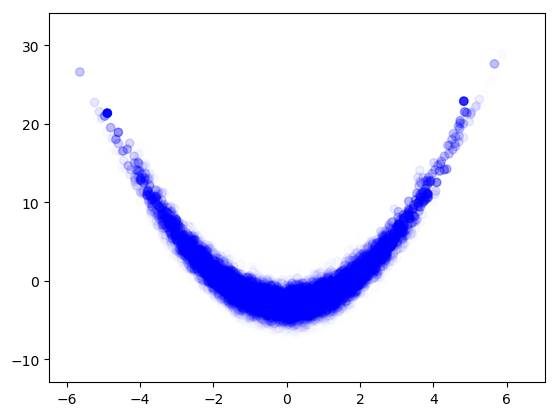

PyObject <matplotlib.collections.PathCollection object at 0xa31ca7ac8>

In [59]:
plot_is_vs_target(_S, _W)

In [77]:
tmp = jaff_opt()

jaff_opt
  resample_every: Int64 1
  sqrtdelta: Float64 1.0
  junk: Int64 5


In [78]:
@unpack_jaff_opt tmp

5